#Import the required lib

In [1]:
# !pip install git+https://github.com/forrestbao/pyeeg.git
import numpy as np
# import pyeeg as pe
import pickle as pickle
import pandas as pd
import math

from sklearn import svm
from sklearn.preprocessing import normalize

import os
import time

import pandas as pd
import keras.backend as K
import numpy as np
import pandas as pd
import tensorflow as tf
import scipy.io
from keras.models import Sequential, Model
from keras.layers import Dense, Conv1D, Convolution1D, MaxPooling1D, ZeroPadding1D, Flatten, Dropout, Conv2D, MaxPooling2D
from keras.utils import to_categorical
import keras
from keras.datasets import mnist
from keras import backend as K
import timeit
from keras.optimizers import SGD
#import cv2, numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

# data_preprocessed_python
os.getcwd()
os.chdir('/content/drive/My Drive')

Mounted at /content/drive/


#ASCERTAIN Dataset

<p>The dataset is composed of EEG, ECG, GSR, EMO, SDM signals</p>
<p>There are totally a 58 subjects, and 36 videos<ul><li>NS - number of subjects - 58</li><li>NV - number of videos - 36</li></ul></p>

<p>This also consist of RAW and FEATURE extracted files</p>
<p>The raw file consist of the signals of all those mentioned signals<ul>
<li>The EEG data consist of 58 persons recording, each recordings has the 36 video data</li></p>

the raw gsr consist of data_gsr file which has the required data
shape - (1,5):
timestamp

acc-x

acc-y

acc-z

gsr

similally:
the ecg raw data has Data_ECG which has the required data
shape - (1,6) but for first 8 subjects only have 3 columns - (1, 5,6)

timestamp

acc-x

acc-y

acc-z

ecg from right arm

ecg from left arm


#Preprocessing ASCERTAIN Dataset

In [3]:
# Total number subjects - 58
num_subs = 50 # remaining 8 is for testing
num_video = 36
num_channels = 8

band = [4,8,12,16,25,45] #5 bands
window_size = 256 #Averaging band power of 2 sec
step_size = 16 #Each 0.125 sec update once
sample_rate = 128 #Sampling rate of 128 Hz

subject_list = ['01','02', '03', '04', '05', '06', '07', '08','09'] +[ str(i) for i in range(10, num_subs+1)]
channels = [i for i in range(num_channels)]

feature_dir = '/content/drive/MyDrive/sem8/ascertain/features'
raw_dir = '/content/drive/MyDrive/sem8/ascertain/raw'

save_dir = '/content/drive/MyDrive/sem8/Fear_level_classification/ascertain/'

feature_files = ['/Dt_EEGFeatures.mat', '/Dt_GSRFeatures.mat', '/Dt_Order_Movie.mat','/Dt_SelfReports.mat']
# raw_files = ['/EEGData/EEGData/Movie_P01/EEG_Clip1.mat']
print(subject_list)
print(channels)

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50']
[0, 1, 2, 3, 4, 5, 6, 7]


Available EEG keys: dict_keys(['__header__', '__version__', '__globals__', 'ThisEEG'])
Available GSR keys: dict_keys(['__header__', '__version__', '__globals__', 'timeGSR', 'Data_GSR', 'A_GSR', 'G_GSR', 'V_GSR'])
Available ECG keys: dict_keys(['__header__', '__version__', '__globals__', 'timeECG', 'Data_ECG', 'A_ECG', 'G_ECG', 'V_ECG'])


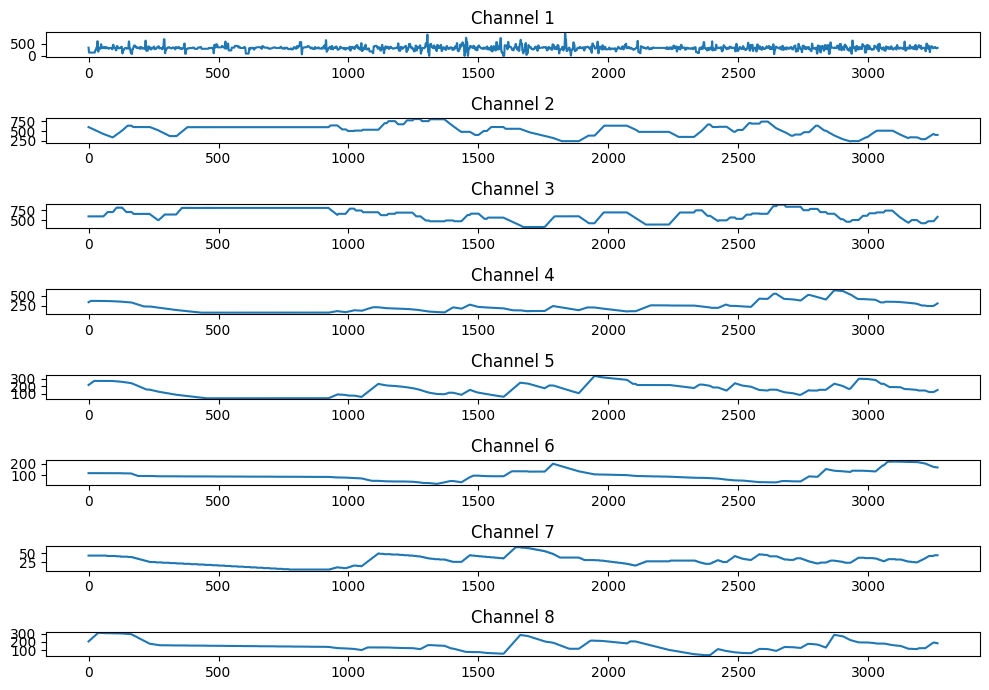

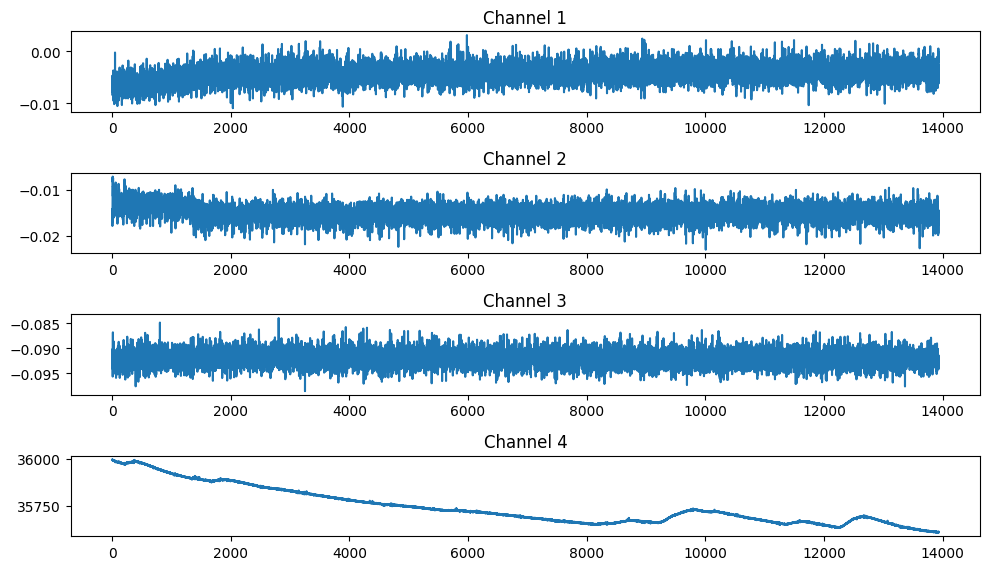

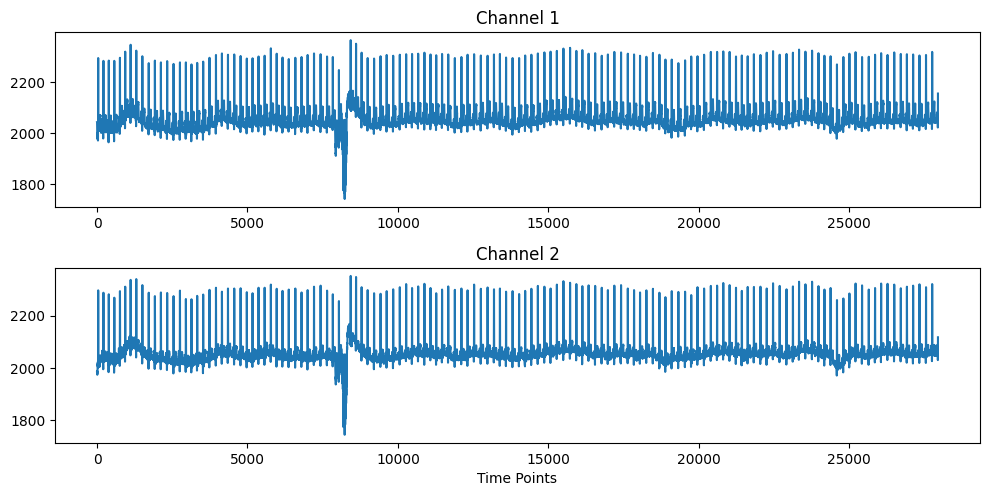

In [22]:
# Visualise the dataset

import scipy.io
import matplotlib.pyplot as plt
import numpy as np

# Load the .mat file
# data = scipy.io.loadmat('ascertain_subject1.mat')  # Update with your actual file path

eeg_data = scipy.io.loadmat(raw_dir + "/EEGData/EEGData/Movie_P" + '01' + '/EEG_Clip1' + '.mat')
gsr_data = scipy.io.loadmat(raw_dir + "/GSRData/GSRData/Movie_P" + '01' + '/GSR_Clip1' + '.mat')
ecg_data = scipy.io.loadmat(raw_dir + "/ECGData/ECGData/Movie_P" + '01' + '/ECG_Clip1' + '.mat')

# Check available keys
print("Available EEG keys:", eeg_data.keys())
print("Available GSR keys:", gsr_data.keys())
print("Available ECG keys:", ecg_data.keys())

# Suppose EEG data is stored in 'EEGdata' with shape (channels, time_points, trials)
# Modify this based on the actual key and structure
eeg_channels = eeg_data['ThisEEG']  # Example key, change if needed
gsr = gsr_data['Data_GSR']
ecg = ecg_data['Data_ECG']

# # Visualize all channels for a single trial (e.g., trial index 0)
trial_index = 0
channels = eeg_channels.shape[0]

plt.figure(figsize=(10, 7))

for i in range(channels):
    plt.subplot(channels, 1, i + 1)
    plt.plot(eeg_channels[i, :])
    plt.title(f'Channel {i + 1}')
    plt.tight_layout()

plt.figure(figsize=(10, 7))
channels = gsr.shape[1]
for i in range(1, channels):
    plt.subplot(channels, 1, i + 1)
    plt.plot(gsr[:, i])
    plt.title(f'Channel {i}')
    plt.tight_layout()

plt.figure(figsize=(10, 7))
channels = ecg.shape[1]
for i in range(1, channels):
    plt.subplot(channels, 1, i + 1)
    plt.plot(ecg[:, i])
    plt.title(f'Channel {i}')
    plt.tight_layout()

plt.xlabel('Time Points')
plt.show()


In [20]:
print(ecg.shape)
print(gsr.shape)

(27946, 3)
(13936, 5)


In [ ]:
# Run this ones to extract the features and store it in the google drive
def FFT_Processing (sub, channel, band, window_size, step_size, sample_rate):
    '''
    arguments:  string subject
                list channel indice
                list band
                int window size for FFT
                int step size for FFT
                int sample rate for FFT
    return:     void
    '''
    print("\nProcessing subject: ", sub)
    label_data = scipy.io.loadmat(feature_dir + feature_files[-1])
    label_data = label_data['Ratings']
    meta = []
    label_sub = []
    for i in range(num_video):
        eeg_data = scipy.io.loadmat(raw_dir + "/EEGData/EEGData/Movie_P" + sub + '/EEG_Clip'+ str(i+1) + '.mat')
        gsr_data = scipy.io.loadmat(raw_dir + "/GSRData/GSRData/Movie_P" + sub + '/GSR_Clip'+ str(i+1) + '.mat')
        ecg_data = scipy.io.loadmat(raw_dir + "/ECGData/ECGData/Movie_P" + sub + '/ECG_Clip'+ str(i+1) + '.mat')
        print("|", end = "")
        # loop over 0-7 trails
        # Since the size - (8, 3267) is of different, 3267/256 = 12.67, try to keep 3072
        data = eeg_data["ThisEEG"]
        gsr = gsr_data["Data_GSR"]
        ecg = ecg_data["Data_ECG"]
        # label - (5,58,36) so destructure and add labels
        labels = [label_data[0][int(sub)-1][i],label_data[1][int(sub)-1][i],label_data[2][int(sub)-1][i],label_data[3][int(sub)-1][i],label_data[4][int(sub)-1][i]]
        start = 0;
        while start + window_size < data.shape[1]:
            meta_array = []
            meta_data = [] #meta vector for analysis
            for j in channel:
                X = data[j][start : start + window_size] #Slice raw data over 2 sec, at interval of 0.125 sec
                Y = pe.bin_power(X, band, sample_rate) #FFT over 2 sec of channel j, in seq of theta, alpha, low beta, high beta, gamma
                meta_data = meta_data + list(Y[0])

            # GSR Signals - Time-domain features (e.g., mean, variance, etc.)
            for k in range(1,5): # 8 features
              X = gsr[start : start + window_size]
              pps_mean = np.mean(X)
              pps_var = np.var(X)
              meta_data.append(pps_mean)
              meta_data.append(pps_var)

            # ECG Signals - Time-domain features (e.g., mean, variance, etc.)
            for k in range(-2,0): # 4 features
              X = ecg[start : start + window_size]
              pps_mean = np.mean(X)
              pps_var = np.var(X)
              meta_data.append(pps_mean)
              meta_data.append(pps_var)

            meta_array.append(np.array(meta_data))
            # meta_array.append((labels))
            label_sub.append(np.array([labels]))
            meta.append(np.array(meta_array))
            start = start + step_size

    meta = np.array(meta)
    label_sub = np.array(label_sub)
    np.save(save_dir + '/s' + sub, meta, allow_pickle=True, fix_imports=True)
    np.save(save_dir + '/s_label' + sub, label_sub, allow_pickle=True, fix_imports=True)
    print("\nfiles saved", meta.shape, label_sub.shape)


# FFT_Processing ('01', channels, band, window_size, step_size, sample_rate)
for subject in subject_list:
    FFT_Processing (subject, channels, band, window_size, step_size, sample_rate)


Processing subject:  01
||||||||||||||||||||||||||||||||||||
files saved (5218, 1, 52) (5218, 1, 5)

Processing subject:  02
||||||||||||||||||||||||||||||||||||
files saved (5218, 1, 52) (5218, 1, 5)

Processing subject:  03
||||||||||||||||||||||||||||||||||||
files saved (5218, 1, 52) (5218, 1, 5)

Processing subject:  04
||||||||||||||||||||||||||||||||||||
files saved (5218, 1, 52) (5218, 1, 5)

Processing subject:  05
||||||||||||||||||||||||||||||||||||
files saved (5218, 1, 52) (5218, 1, 5)

Processing subject:  06
||||||||||||||||||||||||||||||||||||
files saved (5219, 1, 52) (5219, 1, 5)

Processing subject:  07
||||||||||||||||||||||||||||||||||||
files saved (5218, 1, 52) (5218, 1, 5)

Processing subject:  08
||||||||||||||||||||||||||||||||||||
files saved (5218, 1, 52) (5218, 1, 5)

Processing subject:  09
||||||||||||||||||||||||||||||||||||
files saved (5218, 1, 52) (5218, 1, 5)

Processing subject:  10
||||||||||||||||||||||||||||||||||||
files saved (5218, 1, 52) (52

###Create the training and testing set

In [ ]:
subject_list = ['01','02', '03', '04', '05', '06', '07', '08','09', '10'] + [ str(i) for i in range(10, num_subs+1)]
data_training = []
label_training = []
data_testing = []
label_testing = []

for subjects in subject_list:

    with open(save_dir + "/s" + subjects + '.npy', 'rb') as file:
      sub = np.load(file,allow_pickle=True)
      for i in range (0,sub.shape[0]):
        if i % 5 == 0:
          data_testing.append(sub[i][0])
        else:
          data_training.append(sub[i][0])

for subjects in subject_list:

    with open(save_dir + "/s_label" + subjects + '.npy', 'rb') as file:
      sub = np.load(file,allow_pickle=True)
      for i in range (0,sub.shape[0]):
        if i % 5 == 0:
          label_testing.append(sub[i][0])
        else:
          label_training.append(sub[i][0])

print("number of subject included: ", len(subject_list))
np.save(save_dir + '/data_training', np.array(data_training), allow_pickle=True, fix_imports=True)
np.save(save_dir + '/label_training', np.array(label_training), allow_pickle=True, fix_imports=True)
print("training dataset:", np.array(data_training).shape, np.array(label_training).shape)

np.save(save_dir + '/data_testing', np.array(data_testing), allow_pickle=True, fix_imports=True)
np.save(save_dir + '/label_testing', np.array(label_testing), allow_pickle=True, fix_imports=True)
print("testing dataset:", np.array(data_testing).shape, np.array(label_testing).shape)

number of subject included:  51
training dataset: (407630, 52) (407630, 5)
testing dataset: (101934, 52) (101934, 5)


###Read the train and test data

In [ ]:
with open(save_dir+ '/data_training.npy', 'rb') as fileTrain:
    X  = np.load(fileTrain)

with open(save_dir + '/label_training.npy', 'rb') as fileTrainL:
    Y  = np.load(fileTrainL)


print(X.shape)
print(Y.shape)
# X = normalize(X)
# Reshape X to be a 2D array before normalization
X = np.nan_to_num(X)
X = normalize(X)
Z = np.ravel(Y[:, [0]])

from keras.utils import to_categorical
x_train = np.array(X[:])
y_train = to_categorical(Z)

print(x_train.shape)
print(y_train.shape)

(407630, 52)
(407630, 5)
(407630, 52)
(407630, 7)


In [ ]:
with open(save_dir + '/data_testing.npy', 'rb') as fileTrain:
    M  = np.load(fileTrain)

with open(save_dir + '/label_testing.npy', 'rb') as fileTrainL:
    N  = np.load(fileTrainL)

M = np.nan_to_num(M)
M = normalize(M)
L = np.ravel(N[:, [0]])

from keras.utils import to_categorical
x_test = np.array(M[:])
y_test = to_categorical(L)
y_test

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

x_train = x_train.reshape(x_train.shape[0],x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1], 1)
print(x_train.shape)
print(x_test.shape)
print("\n\n")

X_test, X_val, Y_test, Y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

# Convert lists to numpy arrays if needed
X_test = np.array(X_test)
X_val = np.array(X_val)
Y_test = np.array(Y_test)
Y_val = np.array(Y_val)

print("x_train shape", x_train.shape)
print("X_test shape:", X_test.shape)
print("X_val shape:", X_val.shape)
print("y_train shape", y_train.shape)
print("Y_test shape:", Y_test.shape)
print("Y_val shape:", Y_val.shape)

(407630, 52, 1)
(101934, 52, 1)



x_train shape (407630, 52, 1)
X_test shape: (50967, 52, 1)
X_val shape: (50967, 52, 1)
y_train shape (407630, 7)
Y_test shape: (50967, 7)
Y_val shape: (50967, 7)


#Fear data extraction from the ASCERTAIN dataset

<h3>Typical Fear Characteristics:</h3>
<ul>
<li>High Arousal: Fear is a high-arousal emotion.</li>

<li>Negative Valence: Fear is a negative emotion.</li>

<li>High Engagement: Fear often involves high engagement (e.g., heightened attention).</li>

<li>Low Liking: Fear is not a liked emotion.</li>

<li>Low Familiarity: Unfamiliar stimuli may induce fear.</li>
</ul>

<h3>Proposed Mapping to Fear States:</h3>
Based on the value ranges, you can categorize fear as follows:
<table>
<tr><th>Fear State</th>	<th>Arousal</th>	<th>Valence</th>	<th>Engagement</th>	<th>Liking</th>	<th>Familiarity</th></tr>
<tr>
<td>Relaxed</td>	<td>0-2</td>	<td>1-3</td>	<td>0-2</td>	<td>5-6</td> <td>2-4</td>
</tr>
<tr>
<td>Low Fear</td>	<td>3-4</td>	<td>-1 to -2</td>	<td>3-4</td>	<td>3-4</td>	<td>1-2</td></tr>
<tr>
<td>Medium Fear</td>	<td>4-5</td>	<td>-2 to -3</td>	<td>4-5</td>	<td>1-2</td>	<td>0-1</td></tr>
<tr>
<td>High Fear</td>	<td>5-6</td>	<td>-3</td>	<td>5-6</td>	<td>0-1</td>	<td>0</td></tr>
</table>
<p>But we now only consider the Arousal, valence, liking, Familiarity</p>

In [ ]:
subject_list = ['01','02', '03', '04', '05', '06', '07', '08','09'] +[ str(i) for i in range(10, num_subs+1)]

sub_data = {}
relax = 0
low_fear = 0
medium_fear = 0
high_fear = 0
total = []

for subjects in subject_list:
    sub_data[subjects] = {'relax': 0, 'low': 0, 'medium': 0, 'high':0}
    with open(save_dir + "/s" + subjects + '.npy', 'rb') as data_file:
      with open(save_dir + "/s_label" + subjects + '.npy', 'rb') as label_file:
        data = np.load(data_file,allow_pickle=True)
        label = np.load(label_file,allow_pickle=True)
        for i in range (0,label.shape[0]):
          if label[i][0][0] >=0 and label[i][0][0] <=2 and label[i][0][1] >=1 and label[i][0][1] <= 3 and label[i][0][3] >=5 and label[i][0][3] <=6 and label[i][0][4] >2 and label[i][0][4]<=4:
            relax += 1
            sub_data[subjects]['relax'] += 1
            total.append(data[i][0].tolist())
            total[-1].append(0)
          elif label[i][0][0] >=3 and label[i][0][0] < 4 and label[i][0][1] >=-1 and label[i][0][1] <= 1 and label[i][0][3] >=3 and label[i][0][3] <=4 and label[i][0][4] > 1 and label[i][0][4]<=2:
            low_fear += 1
            sub_data[subjects]['low'] += 1
            total.append(data[i][0].tolist())
            total[-1].append(1)
          elif label[i][0][0] >=4 and label[i][0][0] <5 and label[i][0][1] >=-2 and label[i][0][1] < -1 and label[i][0][3] >=1 and label[i][0][3] <=2 and label[i][0][4]>0 and label[i][0][4]<=1:
            medium_fear += 1
            sub_data[subjects]['medium'] += 1
            total.append(data[i][0].tolist())
            total[-1].append(2)
          elif label[i][0][0] >=5 and label[i][0][0] <=6 and label[i][0][1] >=-3 and label[i][0][1] < -2 and label[i][0][3] >=0 and label[i][0][3] <1 and label[i][0][4]>=0 and label[i][0][4]<1:
            high_fear += 1
            sub_data[subjects]['high'] += 1
            total.append(data[i][0].tolist())
            total[-1].append(3)

print("number of subject included: ", len(subject_list))
print("Relaxed: ", relax)
print("Low Fear: ", low_fear)
print("Medium Fear: ", medium_fear)
print("High Fear: ", high_fear)

print("total data selected:", len(total))

print('\nData selected w.r.t subject:')
for i in sub_data.keys():
  print('subject:', i, sub_data[i])

np.save(save_dir + '/fear_data/fear_data', np.array(total), allow_pickle=True, fix_imports=True)
print("fear dataset:", np.array(total).shape)

number of subject included:  50
Relaxed:  8405
Low Fear:  3514
Medium Fear:  3646
High Fear:  4577
total data selected: 20142

Data selected w.r.t subject:
subject: 01 {'relax': 0, 'low': 0, 'medium': 0, 'high': 0}
subject: 02 {'relax': 163, 'low': 0, 'medium': 0, 'high': 105}
subject: 03 {'relax': 165, 'low': 87, 'medium': 0, 'high': 0}
subject: 04 {'relax': 0, 'low': 0, 'medium': 0, 'high': 0}
subject: 05 {'relax': 145, 'low': 0, 'medium': 0, 'high': 0}
subject: 06 {'relax': 0, 'low': 0, 'medium': 0, 'high': 0}
subject: 07 {'relax': 0, 'low': 0, 'medium': 0, 'high': 0}
subject: 08 {'relax': 0, 'low': 0, 'medium': 0, 'high': 0}
subject: 09 {'relax': 0, 'low': 0, 'medium': 0, 'high': 0}
subject: 10 {'relax': 244, 'low': 0, 'medium': 0, 'high': 0}
subject: 11 {'relax': 89, 'low': 0, 'medium': 0, 'high': 0}
subject: 12 {'relax': 0, 'low': 155, 'medium': 0, 'high': 0}
subject: 13 {'relax': 0, 'low': 0, 'medium': 0, 'high': 0}
subject: 14 {'relax': 165, 'low': 0, 'medium': 0, 'high': 0}
su

In [ ]:
with open(save_dir+ '/fear_data/fear_data.npy', 'rb') as fear_data:
    X  = np.load(fear_data)

X = np.nan_to_num(X)
print(X.shape)

x = np.array(X[:, :-1])
x = normalize(x)
y = np.array(X[:, -1])
print('\nx and y:')
print(x.shape)
print(y.shape)

# x and y:
# (95920, 52)
# (95920,)

(20142, 53)

x and y:
(20142, 52)
(20142,)


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
fx_train = scaler.fit_transform(x)
fx_train = fx_train.reshape(fx_train.shape[0],fx_train.shape[1], 1)
fy_train = to_categorical(y)

fX_train, fX_test, fY_train, fY_test = train_test_split(fx_train, fy_train, test_size=0.7, random_state=42)
fX_test, fX_val, fY_test, fY_val = train_test_split(fx_train, fy_train, test_size=0.5, random_state=42)

# Convert lists to numpy arrays if needed
fX_train = np.array(fX_train)
fY_train = np.array(fY_train)
fX_test = np.array(fX_test)
fX_val = np.array(fX_val)
fY_test = np.array(fY_test)
fY_val = np.array(fY_val)

print("X_train shape", fx_train.shape)
print("X_test shape:", fX_test.shape)
print("X_val shape:", fX_val.shape)
print("Y_train shape", fy_train.shape)
print("Y_test shape:", fY_test.shape)
print("Y_val shape:", fY_val.shape)

X_train shape (20142, 52, 1)
X_test shape: (10071, 52, 1)
X_val shape: (10071, 52, 1)
Y_train shape (20142, 4)
Y_test shape: (10071, 4)
Y_val shape: (10071, 4)


#Model Training

##CNN model

In [ ]:
from keras.layers import Convolution1D, ZeroPadding1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Flatten, Dense
from keras.regularizers import l2

batch_size = 256
num_classes = 7
epochs = 50
input_shape=(x_train.shape[1], 1)
print(input_shape)

(52, 1)


In [ ]:
cnn_model = Sequential()
intput_shape=(x_train.shape[1], 1)
cnn_model.add(Conv1D(128, kernel_size=3,padding = 'same',activation='relu', input_shape=input_shape))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling1D(pool_size=(2)))
# cnn_model.add(Conv1D(128,kernel_size=3,padding = 'same', activation='relu'))
# cnn_model.add(BatchNormalization())
# cnn_model.add(MaxPooling1D(pool_size=(2)))
# cnn_model.add(Conv1D(128,kernel_size=3,padding = 'same', activation='relu'))
# cnn_model.add(BatchNormalization())
# cnn_model.add(MaxPooling1D(pool_size=(2)))
cnn_model.add(Conv1D(128,kernel_size=3,padding = 'same', activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling1D(pool_size=(2)))
cnn_model.add(Conv1D(64,kernel_size=3,padding = 'same', activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=(2)))
cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='tanh'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(32, activation='tanh'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(16, activation='relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(num_classes, activation='softmax'))
cnn_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 52, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 52, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 26, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 26, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 26, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 13, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 13, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 7)              │           119 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,823 (401.65 KB)

 Trainable params: 102,311 (399.65 KB)

 Non-trainable params: 512 (2.00 KB)

In [ ]:
cnn_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
cnn_history = cnn_model.fit(x_train, y_train,
          batch_size=64,
          epochs=100,
          verbose=1,validation_data=(X_val,Y_val))

# cnn_model.save('/content/drive/MyDrive/sem8/Fear_level_classification/models/cnn_model_ascertain_v1.keras')

Epoch 1/100
6370/6370 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - accuracy: 0.3347 - loss: 1.6394 - val_accuracy: 0.3524 - val_loss: 1.6018
Epoch 2/100
6370/6370 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.3576 - loss: 1.5714 - val_accuracy: 0.3677 - val_loss: 1.5308
Epoch 3/100
6370/6370 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.3688 - loss: 1.5408 - val_accuracy: 0.3779 - val_loss: 1.5211
Epoch 4/100
6370/6370 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.3735 - loss: 1.5329 - val_accuracy: 0.3795 - val_loss: 1.5015
Epoch 5/100
6370/6370 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.3816 - loss: 1.5133 - val_accuracy: 0.3689 - val_loss: 1.5323
Epoch 6/100
6370/6370 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.3821 - loss: 1.5089 - val_accuracy: 0.3865 - val_loss: 1.4689
Epoch 7/100
6370/6370 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.3887 - loss: 1.4952 - val_accuracy: 0.3815 - val_loss: 1.4916
Epoch 8/100
6370/6370 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - accuracy: 0.3924 -

KeyboardInterrupt: 

In [ ]:
# cnn_model = tf.keras.models.load_model('/content/drive/MyDrive/sem8/Fear_level_classification/models/cnn_model_ascertain_v1.keras')
score = cnn_model.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# output:
# Test loss: 1.337266445159912
# Test accuracy: 0.462024450302124

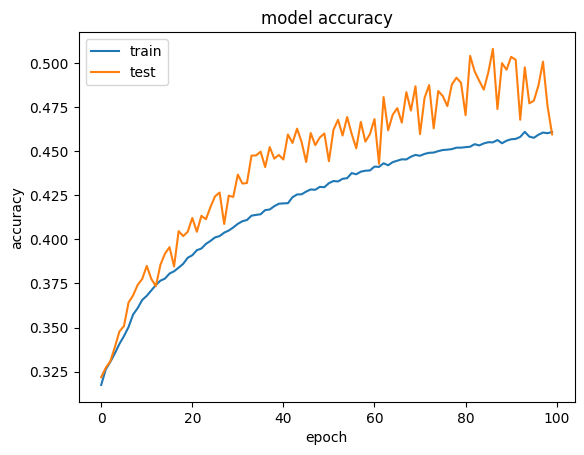

In [ ]:
import matplotlib.pyplot as plt
import numpy# summarize history for accuracy
history = cnn_history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

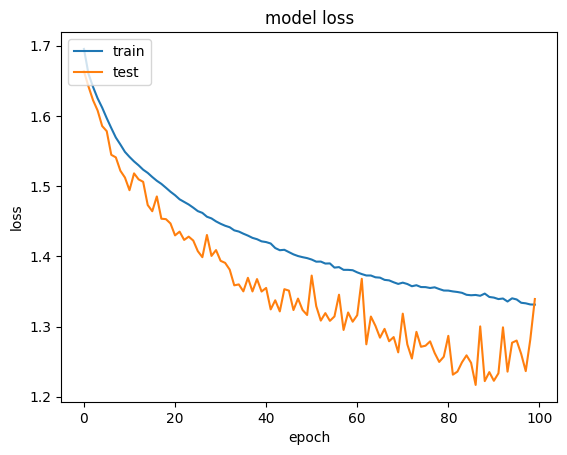

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##LSTM model

In [ ]:
from keras.layers import Convolution1D, ZeroPadding1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Flatten, Dense
from keras.regularizers import l2
from keras.layers import Bidirectional
from keras.layers import LSTM

batch_size = 1024
num_classes = 7
epochs = 20
input_shape=(x_train.shape[1], 1)

In [ ]:
lstm_model = Sequential()

lstm_model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape))
lstm_model.add(Dropout(0.6))
lstm_model.add(LSTM(units = 128, return_sequences = True))
lstm_model.add(Dropout(0.6))
lstm_model.add(LSTM(units = 32))
lstm_model.add(Dropout(0.4))
lstm_model.add(Dense(units = 32))
lstm_model.add(Activation('relu'))
lstm_model.add(Dense(units = 16))
lstm_model.add(Activation('relu'))
lstm_model.add(Dense(units = 16))
lstm_model.add(Activation('relu'))

lstm_model.add(Dense(units = num_classes))
lstm_model.add(Activation('softmax'))
lstm_model.compile(optimizer ="adam", loss =keras.losses.categorical_crossentropy,metrics=["accuracy"])
lstm_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 52, 256)        │       133,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 52, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 52, 128)        │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 52, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 32)             │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 7)              │           119 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 7)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 352,823 (1.35 MB)

 Trainable params: 352,823 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
lstm_history = lstm_model.fit(x_train, y_train,epochs=100,batch_size=1024,verbose=1,validation_data=(X_val, Y_val))
# Save the model to a directory
lstm_model.save('/content/drive/MyDrive/sem8/Fear_level_classification/models/lstm_model_ascertain_v1.keras')

Epoch 1/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 32s 80ms/step - accuracy: 0.3242 - loss: 1.6479 - val_accuracy: 0.3198 - val_loss: 1.6453
Epoch 2/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 41s 79ms/step - accuracy: 0.3223 - loss: 1.6438 - val_accuracy: 0.3211 - val_loss: 1.6405
Epoch 3/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 40s 76ms/step - accuracy: 0.3235 - loss: 1.6427 - val_accuracy: 0.3246 - val_loss: 1.6383
Epoch 4/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 41s 76ms/step - accuracy: 0.3259 - loss: 1.6375 - val_accuracy: 0.3255 - val_loss: 1.6375
Epoch 5/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 31s 77ms/step - accuracy: 0.3256 - loss: 1.6387 - val_accuracy: 0.3236 - val_loss: 1.6376
Epoch 6/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 30s 76ms/step - accuracy: 0.3260 - loss: 1.6368 - val_accuracy: 0.3273 - val_loss: 1.6296
Epoch 7/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 41s 76ms/step - accuracy: 0.3273 - loss: 1.6314 - val_accuracy: 0.3270 - val_loss: 1.6314
Epoch 8/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 41s 76ms/step - accuracy: 0.3294 - loss: 1

In [ ]:
score = lstm_model.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

1593/1593 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.3859 - loss: 1.4955
Test loss: 1.4916398525238037
Test accuracy: 0.38677969574928284


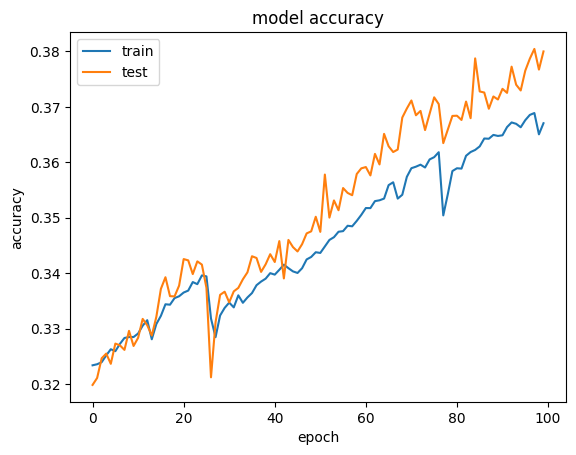

In [ ]:
import matplotlib.pyplot as plt
import numpy# summarize history for accuracy
history = lstm_history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

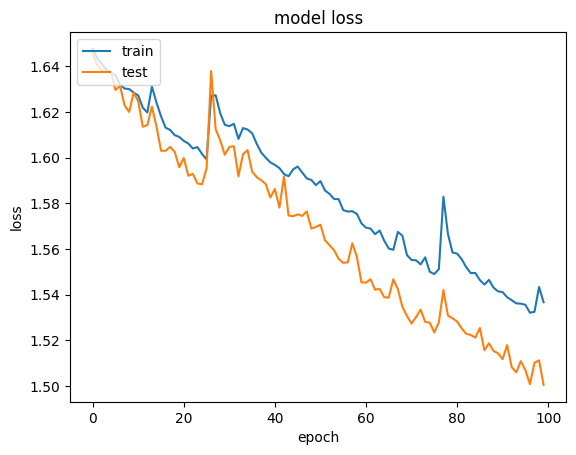

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##GRU model

In [ ]:
from keras.layers import Convolution1D, ZeroPadding1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Flatten, Dense, GRU, Bidirectional
from keras.regularizers import l2

batch_size = 256
num_classes = 7
epochs = 20
input_shape=(x_train.shape[1], 1)

In [ ]:
gru_model = Sequential()

gru_model.add(Bidirectional(GRU(128, return_sequences=True), input_shape=input_shape))
gru_model.add(Dropout(0.6))

gru_model.add(GRU(units=256, return_sequences=True))
gru_model.add(Dropout(0.6))

gru_model.add(GRU(units=32))
gru_model.add(Dropout(0.4))

gru_model.add(Dense(units=32))
gru_model.add(Activation('relu'))

gru_model.add(Dense(units=16))
gru_model.add(Activation('relu'))

gru_model.add(Dense(units=16))
gru_model.add(Activation('relu'))

gru_model.add(Dense(units=num_classes))
gru_model.add(Activation('softmax'))

gru_model.compile(optimizer="adam", loss=keras.losses.categorical_crossentropy, metrics=["accuracy"])
gru_model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional) │ (None, 52, 256)        │       100,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 52, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 52, 256)        │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 52, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 32)             │        27,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 7)              │           119 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 7)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 525,175 (2.00 MB)

 Trainable params: 525,175 (2.00 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
gru_history = gru_model.fit(x_train, y_train,epochs=100,batch_size=1024,verbose=1,validation_data=(X_val, Y_val))
# Save the model to a directory
lstm_model.save('/content/drive/MyDrive/sem8/Fear_level_classification/models/gru_model_ascertain_v1.keras')

Epoch 1/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 43s 99ms/step - accuracy: 0.2995 - loss: 1.7268 - val_accuracy: 0.3158 - val_loss: 1.6884
Epoch 2/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 40s 99ms/step - accuracy: 0.3201 - loss: 1.6829 - val_accuracy: 0.3160 - val_loss: 1.6767
Epoch 3/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 41s 100ms/step - accuracy: 0.3204 - loss: 1.6700 - val_accuracy: 0.3174 - val_loss: 1.6633
Epoch 4/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 40s 98ms/step - accuracy: 0.3217 - loss: 1.6588 - val_accuracy: 0.3192 - val_loss: 1.6486
Epoch 5/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 39s 97ms/step - accuracy: 0.3226 - loss: 1.6495 - val_accuracy: 0.3180 - val_loss: 1.6414
Epoch 6/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 39s 97ms/step - accuracy: 0.3230 - loss: 1.6437 - val_accuracy: 0.3209 - val_loss: 1.6370
Epoch 7/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 42s 100ms/step - accuracy: 0.3239 - loss: 1.6353 - val_accuracy: 0.3292 - val_loss: 1.6192
Epoch 8/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 41s 99ms/step - accuracy: 0.3279 - loss:

In [ ]:
score = gru_model.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

1593/1593 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.5760 - loss: 1.0345
Test loss: 1.0272362232208252
Test accuracy: 0.5797672867774963


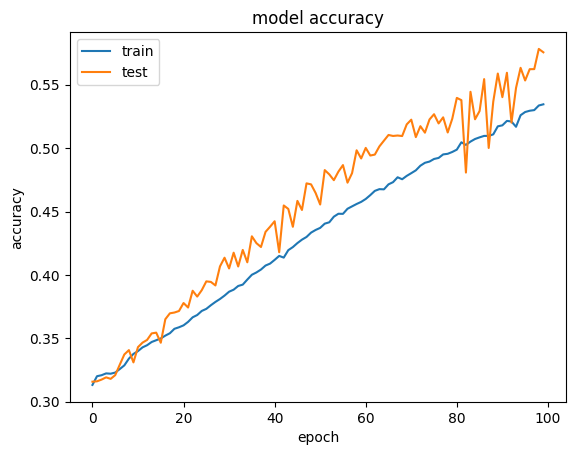

In [ ]:
import matplotlib.pyplot as plt
import numpy# summarize history for accuracy
history = gru_history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

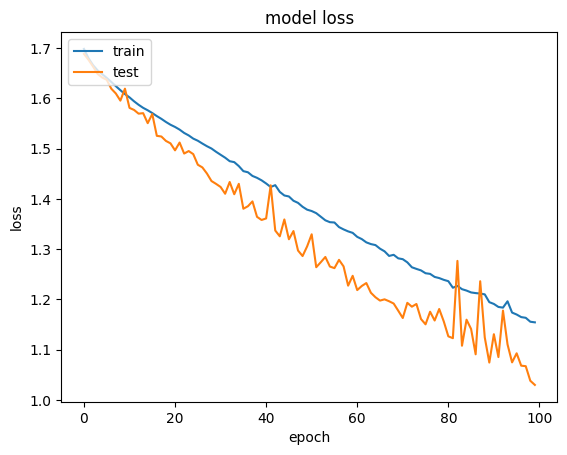

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#Fine tuning

###Fine-tuning CNN

In [ ]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

cnn_model = tf.keras.models.load_model('/content/drive/MyDrive/sem8/Fear_level_classification/models/cnn_model_ascertain_v1.keras')

batch_size = 256
# Assume 'model' is your pre-trained backbone model
# Define the input shape
input_shape=(fx_train.shape[1], 1)

# Create an Input layer with the correct shape
new_input = Input(shape=input_shape)

# Connect the new input to the first layer of your existing model
x = cnn_model.layers[0](new_input)

# Connect the remaining layers of your existing model
for layer in cnn_model.layers[1:-1]:
    x = layer(x)

# Modify the last layer for 4-class fear detection
# model.layers[-1].trainable = False  # Freeze the previous final layer - Not needed as new output is defined
new_output = Dense(4, activation='softmax', name='fear_output')(x)  # New output layer for 4 classes

# Create a new model with the modified output layer
fine_tuned_cnn_model = Model(inputs=new_input, outputs=new_output)

# Recompile the model for fear detection task
fine_tuned_cnn_model.compile(loss='categorical_crossentropy',
                         optimizer='adam',
                         metrics=['accuracy'])

# Train the model with fear data
ft_cnn_history = fine_tuned_cnn_model.fit(fx_train, fy_train,
                               batch_size=batch_size,
                               epochs=100,
                               verbose=1,
                               validation_data=(fX_val, fY_val))
fine_tuned_cnn_model.save('/content/drive/MyDrive/sem8/Fear_level_classification/models/fine_tuned_cnn_model_ascertain_v1.keras')

Epoch 1/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.3798 - loss: 1.4327 - val_accuracy: 0.5122 - val_loss: 1.0949
Epoch 2/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.4980 - loss: 1.1302 - val_accuracy: 0.5589 - val_loss: 0.9982
Epoch 3/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5279 - loss: 1.0559 - val_accuracy: 0.5882 - val_loss: 0.9335
Epoch 4/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5569 - loss: 0.9920 - val_accuracy: 0.5822 - val_loss: 0.9155
Epoch 5/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5781 - loss: 0.9478 - val_accuracy: 0.6183 - val_loss: 0.8481
Epoch 6/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5917 - loss: 0.9158 - val_accuracy: 0.6433 - val_loss: 0.7924
Epoch 7/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6054 - loss: 0.8819 - val_accuracy: 0.6457 - val_loss: 0.7736
Epoch 8/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6095 - loss: 0.8681 - val_

In [ ]:
fine_tuned_cnn_model = tf.keras.models.load_model('/content/drive/MyDrive/sem8/Fear_level_classification/models/fine_tuned_cnn_model_ascertain_v1.keras')
score = fine_tuned_cnn_model.evaluate(fX_test, fY_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# output:
# Test loss: 0.4674292504787445
# Test accuracy: 0.7947039008140564

1499/1499 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7987 - loss: 0.4642
Test loss: 0.4674292504787445
Test accuracy: 0.7947039008140564


###Fine-tuning GRU

In [ ]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

batch_size = 256

# Assume 'model' is your pre-trained backbone model
input_shape=(fX_train.shape[1], 1)  # Define the input shape

# Create an Input layer with the correct shape
new_input = Input(shape=input_shape)

# Connect the new input to the first layer of your existing model
x = gru_model.layers[0](new_input)

# Connect the remaining layers of your existing model
for layer in gru_model.layers[1:-1]:
    x = layer(x)

# Modify the last layer for 4-class fear detection
# model.layers[-1].trainable = False  # Freeze the previous final layer - Not needed as new output is defined
new_output = Dense(4, activation='softmax')(x)  # New output layer for 4 classes

# Create a new model with the modified output layer
fine_tuned_gru_model = Model(inputs=new_input, outputs=new_output)

# Recompile the model for fear detection task
fine_tuned_gru_model.compile(loss='categorical_crossentropy',
                         optimizer='adam',
                         metrics=['accuracy'])

# Train the model with fear data
ft_gru_history = fine_tuned_gru_model.fit(fX_train, fY_train,
                               batch_size=batch_size,
                               epochs=100,
                               verbose=1,
                               validation_data=(fX_val, fY_val))

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.4228 - loss: 1.3914 - val_accuracy: 0.5599 - val_loss: 0.9074
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.5533 - loss: 0.9790 - val_accuracy: 0.5911 - val_loss: 0.8859
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.5716 - loss: 0.9336 - val_accuracy: 0.6243 - val_loss: 0.8102
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.5975 - loss: 0.8636 - val_accuracy: 0.6752 - val_loss: 0.7610
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.6123 - loss: 0.8411 - val_accuracy: 0.6638 - val_loss: 0.7265
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.6291 - loss: 0.8173 - val_accuracy: 0.7043 - val_loss: 0.6943
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.6440 - loss: 0.7903 - val_accuracy: 0.6749 - val_loss: 0.6928
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.6407 - loss: 0.7820 - val_accuracy: 0.

In [ ]:
fine_tuned_gru_model.save('/content/drive/MyDrive/sem8/Fear_level_classification/models/ft_gru_model_ascertain_v1.keras')

In [ ]:
# list all data in history
print(ft_gru_history.history.keys())
score = fine_tuned_gru_model.evaluate(fX_test, fY_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
315/315 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8699 - loss: 0.3139
Test loss: 0.2972736358642578
Test accuracy: 0.8721080422401428


#Knowledge Distillation

<p>This is done by previously trained student model on DEAP dataset is used for trainng in the ASCERTAIN dataset also</p>

###Read the dataset DEAP and ASCERTAIN

In [4]:
#Read the fear data from the DEAP dataset
fear_dir = "/content/drive/MyDrive/sem8/Fear_level_classification/fear_data/full_channels"
with open(fear_dir + '/f_data_training.npy', 'rb') as fileTrain:
    X  = np.load(fileTrain)

with open(fear_dir + '/f_label_training.npy', 'rb') as fileTrainL:
    Y  = np.load(fileTrainL)

print(X.shape)
print(Y.shape)
# X = normalize(X)
# Reshape X to be a 2D array before normalization
X = normalize(X)
from keras.utils import to_categorical
x_train = np.array(X[:])
y_train = np.array(Y[:])
# y_train = to_categorical(Y)

print('Training shape:')
print(X.shape)
print(x_train.shape)
print(y_train.shape)

with open(fear_dir + '/data_testing.npy', 'rb') as fileTrain:
    M  = np.load(fileTrain)

with open(fear_dir + '/label_testing.npy', 'rb') as fileTrainL:
    N  = np.load(fileTrainL)

M = normalize(M)
x_test = np.array(M[:])
y_test = np.array(N[:])

print('\nTesting shape:')
print(x_test.shape)
print(y_test.shape)

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
fx_train = scaler.fit_transform(x_train)
fx_test = scaler.fit_transform(x_test)
fx_train = fx_train.reshape(fx_train.shape[0],fx_train.shape[1], 1)
fx_test = fx_test.reshape(fx_test.shape[0],fx_test.shape[1], 1)
print(fx_train.shape)
print(fx_test.shape)
fy_test = y_test
deap_fy_train = y_train

print('\n\n')

fX_test, fX_val, fY_test, fY_val = train_test_split(fx_test, fy_test, test_size=0.5, random_state=42)

# Convert lists to numpy arrays if needed
fX_test = np.array(fX_test)
fX_val = np.array(fX_val)
deap_fY_test = np.array(fY_test)
deap_fY_val = np.array(fY_val)

# store the full channels for soft-targets calculations
full_deap_fx_train = fx_train

print("X_train shape", fx_train.shape)
print("X_test shape:", fX_test.shape)
print("X_val shape:", fX_val.shape)
print("Y_train shape", deap_fy_train.shape)
print("Y_test shape:", deap_fY_test.shape)
print("Y_val shape:", deap_fY_val.shape)

channel = [0,1,2,16,17,19]
batch_size = 256
fear_dir = "/content/drive/MyDrive/sem8/Fear_level_classification/fear_data"

new_channels = []

for i in channel:
  for j in range(5):
    new_channels.append(i*5+j)

# Append the GSR channels of mean and std
new_channels.append(168)
new_channels.append(169)
print(new_channels)

# Concatenate the specified channels with the last 16 columns
columns_to_extract = new_channels

deap_fx_train = fx_train[:, columns_to_extract]
deap_fx_test = fX_test[:, columns_to_extract]
deap_fx_val = fX_val[:, columns_to_extract]
print('\nAfter reducing:')
print(deap_fx_train.shape)
print(deap_fx_test.shape)
print(deap_fx_val.shape )

(48400, 176)
(48400, 4)
Training shape:
(48400, 176)
(48400, 176)
(48400, 4)

Testing shape:
(12112, 176)
(12112, 4)
(48400, 176, 1)
(12112, 176, 1)



X_train shape (48400, 176, 1)
X_test shape: (6056, 176, 1)
X_val shape: (6056, 176, 1)
Y_train shape (48400, 4)
Y_test shape: (6056, 4)
Y_val shape: (6056, 4)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 95, 96, 97, 98, 99, 168, 169]

After reducing:
(48400, 32, 1)
(6056, 32, 1)
(6056, 32, 1)


In [5]:
# Read the  fear data of ASCERTAIN dataset
save_dir = '/content/drive/MyDrive/sem8/Fear_level_classification/ascertain/'
with open(save_dir+ '/fear_data/fear_data.npy', 'rb') as fear_data:
    X  = np.load(fear_data)

X = np.nan_to_num(X)
print(X.shape)

x = np.array(X[:, :-1])
x = normalize(x)
y = np.array(X[:, -1])
print('\nx and y:')
print(x.shape)
print(y.shape)

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
fx_train = scaler.fit_transform(x)
fx_train = fx_train.reshape(fx_train.shape[0],fx_train.shape[1], 1)
fy_train = to_categorical(y)
asc_fy_train = fy_train

fX_train, fX_test, fY_train, fY_test = train_test_split(fx_train, fy_train, test_size=0.7, random_state=42)
fX_test, fX_val, fY_test, fY_val = train_test_split(fx_train, fy_train, test_size=0.5, random_state=42)

# Convert lists to numpy arrays if needed
fX_train = np.array(fX_train)
asc_fY_train = np.array(fY_train)
fX_test = np.array(fX_test)
fX_val = np.array(fX_val)
asc_fY_test = np.array(fY_test)
asc_fY_val = np.array(fY_val)

# store the full channels for soft-targets calculations
full_asc_fx_train = fx_train

print("X_train shape", fx_train.shape)
print("X_test shape:", fX_test.shape)
print("X_val shape:", fX_val.shape)
print("Y_train shape", asc_fy_train.shape)
print("Y_test shape:", asc_fY_test.shape)
print("Y_val shape:", asc_fY_val.shape)

channel = [0,1,2,3,4,5]
batch_size = 256
fear_dir = "/content/drive/MyDrive/sem8/Fear_level_classification/fear_data"

new_channels = []

for i in channel:
  for j in range(5):
    new_channels.append(i*5+j)

# Append the GSR channels of mean and std
new_channels.append(46)
new_channels.append(47)
print(new_channels)

# Concatenate the specified channels with the last 16 columns
columns_to_extract = new_channels
print(columns_to_extract)

asc_fx_train = fx_train[:, columns_to_extract]
asc_fx_test = fX_test[:, columns_to_extract]
asc_fx_val = fX_val[:, columns_to_extract]
print(asc_fx_train.shape)
print(asc_fx_test.shape)
print(asc_fx_val.shape )

(20142, 53)

x and y:
(20142, 52)
(20142,)
X_train shape (20142, 52, 1)
X_test shape: (10071, 52, 1)
X_val shape: (10071, 52, 1)
Y_train shape (20142, 4)
Y_test shape: (10071, 4)
Y_val shape: (10071, 4)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 46, 47]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 46, 47]
(20142, 32, 1)
(10071, 32, 1)
(10071, 32, 1)


###Using CNN as student model

In [ ]:
from keras.layers import Convolution1D, ZeroPadding1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Flatten, Dense
from keras.regularizers import l2


stud_cnn_model = Sequential()
input_shape=(asc_fx_train.shape[1], 1)
stud_cnn_model.add(Conv1D(128, kernel_size=3,padding = 'same',activation='relu',
                          input_shape=input_shape))
stud_cnn_model.add(BatchNormalization())
stud_cnn_model.add(MaxPooling1D(pool_size=(2)))
stud_cnn_model.add(Conv1D(128,kernel_size=3,padding = 'same', activation='relu'))
stud_cnn_model.add(BatchNormalization())
stud_cnn_model.add(MaxPooling1D(pool_size=(2)))
stud_cnn_model.add(Conv1D(64,kernel_size=3,padding = 'same', activation='relu'))
stud_cnn_model.add(MaxPooling1D(pool_size=(2)))
stud_cnn_model.add(Flatten())
stud_cnn_model.add(Dense(64, activation='tanh'))
stud_cnn_model.add(Dropout(0.2))
stud_cnn_model.add(Dense(16, activation='relu'))
stud_cnn_model.add(Dropout(0.2))
stud_cnn_model.add(Dense(4, activation='softmax'))
stud_cnn_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 32, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 16, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 16, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 8, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 8, 64)          │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,012 (363.33 KB)

 Trainable params: 92,500 (361.33 KB)

 Non-trainable params: 512 (2.00 KB)

####With hard labels

In [ ]:
# Recompile the model for fear detection task
stud_cnn_model.compile(loss='categorical_crossentropy',
                         optimizer='adam',
                         metrics=['accuracy'])

# Train the model with fear data
stud_cnn_history = stud_cnn_model.fit(asc_fx_train, asc_fy_train,
                               batch_size=batch_size,
                               epochs=100,
                               verbose=1,
                               validation_data=(asc_fx_val, asc_fY_val))

Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 0.3746 - loss: 1.3110 - val_accuracy: 0.4179 - val_loss: 1.3110
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4562 - loss: 1.1651 - val_accuracy: 0.3836 - val_loss: 1.3324
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4861 - loss: 1.1073 - val_accuracy: 0.4234 - val_loss: 1.4976
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5238 - loss: 1.0445 - val_accuracy: 0.4178 - val_loss: 1.6713
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5417 - loss: 1.0025 - val_accuracy: 0.4245 - val_loss: 1.6106
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5705 - loss: 0.9477 - val_accuracy: 0.4404 - val_loss: 1.6390
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5908 - loss: 0.9081 - val_accuracy: 0.5190 - val_loss: 1.1242
Epoch 8/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5981 - loss: 0.8851 - val_accuracy: 0.5110 -

In [ ]:
stud_cnn_model.save('/content/drive/MyDrive/sem8/Fear_level_classification/models/stud_cnn_model_asc_wkd.keras')

In [ ]:
stud_cnn_model = tf.keras.models.load_model('/content/drive/MyDrive/sem8/Fear_level_classification/models/stud_cnn_model_asc_wkd.keras')
score = stud_cnn_model.evaluate(asc_fx_test, asc_fY_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

315/315 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8466 - loss: 0.3460
Test loss: 0.3479238450527191
Test accuracy: 0.8454969525337219


####Using Soft-targets from treacher model

In [ ]:
fine_tuned_cnn_model = tf.keras.models.load_model('/content/drive/MyDrive/sem8/Fear_level_classification/models/fine_tuned_cnn_model_ascertain_v1.keras')
soft_targets = fine_tuned_cnn_model.predict(fx_train)

630/630 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [ ]:
# Recompile the model for fear detection task
stud_cnn_model.compile(loss='categorical_crossentropy',
                         optimizer='adam',
                         metrics=['accuracy'])

# Train the model with fear data
stud_cnn_history = stud_cnn_model.fit(asc_fx_train, soft_targets,
                               batch_size=batch_size,
                               epochs=100,
                               verbose=1,
                               validation_data=(asc_fx_val, asc_fY_val))

Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.3874 - loss: 2.9858 - val_accuracy: 0.2533 - val_loss: 2.3476
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.5779 - loss: 0.9713 - val_accuracy: 0.2120 - val_loss: 2.8464
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6540 - loss: 0.8712 - val_accuracy: 0.2293 - val_loss: 2.7492
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6998 - loss: 0.8061 - val_accuracy: 0.2320 - val_loss: 2.9691
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7235 - loss: 0.7669 - val_accuracy: 0.2384 - val_loss: 3.1664
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7446 - loss: 0.7359 - val_accuracy: 0.2216 - val_loss: 3.2616
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7696 - loss: 0.7163 - val_accuracy: 0.2274 - val_loss: 3.3720
Epoch 8/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7988 - loss: 0.6873 - val_accuracy: 0.2460 - 

In [ ]:
stud_cnn_model.save('/content/drive/MyDrive/sem8/Fear_level_classification/models/stud_cnn_model_asc_kd.keras')

In [ ]:
stud_cnn_model = tf.keras.models.load_model('/content/drive/MyDrive/sem8/Fear_level_classification/models/stud_cnn_model_asc_kd.keras')
score = stud_cnn_model.evaluate(asc_fx_test, asc_fY_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

315/315 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2453 - loss: 5.0592
Test loss: 5.048488616943359
Test accuracy: 0.24694667756557465


###Using GRU model

In [3]:
from keras.layers import Convolution1D, ZeroPadding1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Flatten, Dense, GRU, Bidirectional
from keras.regularizers import l2

batch_size = 1024
num_classes = 4
epochs = 100
input_shape=(x_train.shape[1], 1)

NameError: name 'x_train' is not defined

In [ ]:
stud_gru_model = Sequential()

stud_gru_model.add(Bidirectional(GRU(128, return_sequences=True), input_shape=input_shape))
stud_gru_model.add(Dropout(0.6))

stud_gru_model.add(GRU(units=256, return_sequences=True))
stud_gru_model.add(Dropout(0.6))

stud_gru_model.add(GRU(units=32))
stud_gru_model.add(Dropout(0.4))

stud_gru_model.add(Dense(units=16))
stud_gru_model.add(Activation('relu'))

stud_gru_model.add(Dense(units=8))
stud_gru_model.add(Activation('relu'))

stud_gru_model.add(Dense(units=8))
stud_gru_model.add(Activation('relu'))

stud_gru_model.add(Dense(units=num_classes))
stud_gru_model.add(Activation('softmax'))

stud_gru_model.compile(optimizer="adam", loss=keras.losses.categorical_crossentropy, metrics=["accuracy"])
stud_gru_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 176, 256)       │       100,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 176, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 176, 256)       │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 176, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 32)             │        27,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 4)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 523,972 (2.00 MB)

 Trainable params: 523,972 (2.00 MB)

 Non-trainable params: 0 (0.00 B)

####Hard Labels

In [ ]:
stud_gru_history = stud_gru_model.fit(asc_fx_train, asc_fy_train,epochs=100,batch_size=1024,verbose=1,validation_data=(asc_fx_val, asc_fY_val))
# Save the model to a directory
stud_gru_model.save('/content/drive/MyDrive/sem8/Fear_level_classification/models/wkd_gru_model_ascertain_v1.keras')

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 114s 5s/step - accuracy: 0.4055 - loss: 1.3453 - val_accuracy: 0.4161 - val_loss: 1.2774
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 128s 4s/step - accuracy: 0.4182 - loss: 1.2804 - val_accuracy: 0.4161 - val_loss: 1.2488
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 92s 5s/step - accuracy: 0.4184 - loss: 1.2496 - val_accuracy: 0.4187 - val_loss: 1.2343
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 88s 4s/step - accuracy: 0.4223 - loss: 1.2401 - val_accuracy: 0.4197 - val_loss: 1.2235
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 191s 7s/step - accuracy: 0.4186 - loss: 1.2316 - val_accuracy: 0.4204 - val_loss: 1.2181
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 117s 5s/step - accuracy: 0.4197 - loss: 1.2255 - val_accuracy: 0.4191 - val_loss: 1.2116
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 128s 5s/step - accuracy: 0.4247 - loss: 1.2166 - val_accuracy: 0.4213 - val_loss: 1.2073
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 99s 5s/step - accuracy: 0.4204 - loss: 1.2164 - val_accuracy: 0.422

In [ ]:
score = stud_gru_model.evaluate(asc_fx_test, asc_fY_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

315/315 ━━━━━━━━━━━━━━━━━━━━ 18s 58ms/step - accuracy: 0.7017 - loss: 0.6742
Test loss: 0.67853844165802
Test accuracy: 0.7028100490570068


####Soft-targets

In [ ]:
fine_tuned_gru_model = tf.keras.models.load_model('/content/drive/MyDrive/sem8/Fear_level_classification/models/ft_gru_model_ascertain_v1.keras')

In [ ]:
soft_targets = fine_tuned_gru_model.predict(full_asc_fx_train)

# Recompile the model for fear detection task
stud_gru_model.compile(loss='categorical_crossentropy',
                         optimizer='adam',
                         metrics=['accuracy'])

# Train the model with fear data
stud_gru_history = stud_gru_model.fit(asc_fx_train, soft_targets,
                               batch_size=1024,
                               epochs=100,
                               verbose=1,
                               validation_data=(asc_fx_val, asc_fY_val))
stud_gru_model.save('/content/drive/MyDrive/sem8/Fear_level_classification/models/rf_stud_gru_model_kd.keras')

630/630 ━━━━━━━━━━━━━━━━━━━━ 64s 99ms/step
Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 107s 5s/step - accuracy: 0.3512 - loss: 1.3570 - val_accuracy: 0.3927 - val_loss: 1.2914
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 141s 5s/step - accuracy: 0.4107 - loss: 1.2916 - val_accuracy: 0.4161 - val_loss: 1.2596
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 97s 5s/step - accuracy: 0.4270 - loss: 1.2647 - val_accuracy: 0.4161 - val_loss: 1.2412
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 94s 5s/step - accuracy: 0.4285 - loss: 1.2431 - val_accuracy: 0.4199 - val_loss: 1.2322
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 85s 4s/step - accuracy: 0.4256 - loss: 1.2399 - val_accuracy: 0.4199 - val_loss: 1.2248
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 153s 5s/step - accuracy: 0.4270 - loss: 1.2321 - val_accuracy: 0.4199 - val_loss: 1.2198
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 141s 5s/step - accuracy: 0.4222 - loss: 1.2316 - val_accuracy: 0.4215 - val_loss: 1.2204
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 137s 4s/step - accuracy: 0.4287 -

In [ ]:
score = stud_gru_model.evaluate(asc_fx_test, asc_fY_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

315/315 ━━━━━━━━━━━━━━━━━━━━ 22s 68ms/step - accuracy: 0.5646 - loss: 0.9260
Test loss: 0.9295974373817444
Test accuracy: 0.5597259402275085


##Training with DEAP and ASCERTAIN

In [6]:
# Combine the fear data from the DEAP and ASCERTAIN

r_fx_train = np.concatenate((deap_fx_train, asc_fx_train))
r_fx_test = np.concatenate((deap_fx_test, asc_fx_test))
r_fx_val = np.concatenate((deap_fx_val, asc_fx_val))
r_fy_train = np.concatenate((deap_fy_train, asc_fy_train))
r_fy_test = np.concatenate((deap_fY_test, asc_fY_test))
r_fy_val = np.concatenate((deap_fY_val, asc_fY_val))
print(r_fx_train.shape)
print(r_fx_test.shape)
print(r_fx_val.shape)
print(r_fy_train.shape)
print(r_fy_test.shape)
print(r_fy_val.shape)

(68542, 32, 1)
(16127, 32, 1)
(16127, 32, 1)
(68542, 4)
(16127, 4)
(16127, 4)


###Training CNN model

In [25]:
from keras.layers import Convolution1D, ZeroPadding1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Flatten, Dense
from keras.regularizers import l2

stud_cnn_model = Sequential()
input_shape=(r_fx_train.shape[1], 1)
stud_cnn_model.add(Conv1D(128, kernel_size=3,padding = 'same',activation='relu',
                          input_shape=input_shape))
stud_cnn_model.add(BatchNormalization())
stud_cnn_model.add(MaxPooling1D(pool_size=(2)))
stud_cnn_model.add(Conv1D(128,kernel_size=3,padding = 'same', activation='relu'))
stud_cnn_model.add(BatchNormalization())
stud_cnn_model.add(MaxPooling1D(pool_size=(2)))
stud_cnn_model.add(Flatten())
stud_cnn_model.add(Dense(64, activation='tanh'))
stud_cnn_model.add(Dropout(0.2))
stud_cnn_model.add(Dense(16, activation='relu'))
stud_cnn_model.add(Dropout(0.2))
stud_cnn_model.add(Dense(4, activation='softmax'))
stud_cnn_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 32, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 16, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 16, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 8, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,524 (459.08 KB)

 Trainable params: 117,012 (457.08 KB)

 Non-trainable params: 512 (2.00 KB)

####Training the student model without Knowledge Distillation

In [16]:
# Recompile the model for fear detection task
stud_cnn_model.compile(loss='categorical_crossentropy',
                         optimizer='adam',
                         metrics=['accuracy'])

# Train the model with fear data
stud_cnn_history = stud_cnn_model.fit(r_fx_train, r_fy_train,
                               batch_size=batch_size,
                               epochs=100,
                               verbose=1,
                               validation_data=(r_fx_val, r_fy_val))
stud_cnn_model.save('/content/drive/MyDrive/sem8/Fear_level_classification/models/rf_stud_cnn_model_wkd.keras')

Epoch 1/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.4547 - loss: 1.1789 - val_accuracy: 0.3113 - val_loss: 2.2783
Epoch 2/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5363 - loss: 0.9826 - val_accuracy: 0.4512 - val_loss: 1.1256
Epoch 3/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5697 - loss: 0.9195 - val_accuracy: 0.5130 - val_loss: 0.9787
Epoch 4/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5981 - loss: 0.8687 - val_accuracy: 0.5738 - val_loss: 0.9277
Epoch 5/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6167 - loss: 0.8272 - val_accuracy: 0.5702 - val_loss: 0.9466
Epoch 6/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6378 - loss: 0.7962 - val_accuracy: 0.5881 - val_loss: 0.8883
Epoch 7/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6487 - loss: 0.7714 - val_accuracy: 0.5872 - val_loss: 0.8948
Epoch 8/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6632 - loss: 0.7421 - val_ac

In [17]:
stud_cnn_model = tf.keras.models.load_model('/content/drive/MyDrive/sem8/Fear_level_classification/models/rf_stud_cnn_model_wkd.keras')
print("Over-all test result:")
score = stud_cnn_model.evaluate(r_fx_test, r_fy_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

print("DEAP test result:")
score = stud_cnn_model.evaluate(deap_fx_test, deap_fY_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

print("ASCERTAIN test result:")
score = stud_cnn_model.evaluate(asc_fx_test, asc_fY_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Over-all test result:
# 504/504 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8229 - loss: 0.4242
# Test loss: 0.5756956338882446
# Test accuracy: 0.7425435781478882
# DEAP test result:
# 190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8791 - loss: 0.3206
# Test loss: 0.3100600838661194
# Test accuracy: 0.8809444904327393
# ASCERTAIN test result:
# 315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6575 - loss: 0.7381
# Test loss: 0.7354304194450378
# Test accuracy: 0.6593188643455505

Over-all test result:
504/504 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8229 - loss: 0.4242
Test loss: 0.5756956338882446
Test accuracy: 0.7425435781478882
DEAP test result:
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8791 - loss: 0.3206
Test loss: 0.3100600838661194
Test accuracy: 0.8809444904327393
ASCERTAIN test result:
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6575 - loss: 0.7381
Test loss: 0.7354304194450378
Test accuracy: 0.6593188643455505


####Knowledge Distillation with soft-targets

In [23]:
deap_cnn_model = tf.keras.models.load_model('/content/drive/MyDrive/sem8/Fear_level_classification/models/fine_tuned_cnn_model_v1.keras')
# asc_cnn_model = tf.keras.models.load_model('/content/drive/MyDrive/sem8/Fear_level_classification/models/fine_tuned_cnn_model_ascertain_v1.keras')
asc_cnn_model = tf.keras.models.load_model('/content/drive/MyDrive/sem8/Fear_level_classification/models/ft_gru_model_ascertain_v1.keras')

deap_soft_targets = deap_cnn_model.predict(full_deap_fx_train)
asc_soft_targets = asc_cnn_model.predict(full_asc_fx_train)

soft_targets = np.concatenate((deap_soft_targets, asc_soft_targets))
print(soft_targets.shape)

1513/1513 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
630/630 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
(68542, 4)


In [26]:
# Recompile the model for fear detection task
stud_cnn_model.compile(loss='categorical_crossentropy',
                         optimizer='adam',
                         metrics=['accuracy'])

# Train the model with fear data
stud_cnn_history = stud_cnn_model.fit(r_fx_train, soft_targets,
                               batch_size=batch_size,
                               epochs=100,
                               verbose=1,
                               validation_data=(r_fx_val, r_fy_val))
stud_cnn_model.save('/content/drive/MyDrive/sem8/Fear_level_classification/models/rf_stud_cnn_model_kd.keras')

Epoch 1/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.4578 - loss: 1.1619 - val_accuracy: 0.2803 - val_loss: 1.9283
Epoch 2/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5392 - loss: 0.9880 - val_accuracy: 0.3865 - val_loss: 1.2394
Epoch 3/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5721 - loss: 0.9253 - val_accuracy: 0.5333 - val_loss: 0.9729
Epoch 4/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6005 - loss: 0.8725 - val_accuracy: 0.5508 - val_loss: 0.9307
Epoch 5/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6280 - loss: 0.8216 - val_accuracy: 0.5499 - val_loss: 0.9341
Epoch 6/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6447 - loss: 0.7854 - val_accuracy: 0.5911 - val_loss: 0.8676
Epoch 7/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6529 - loss: 0.7715 - val_accuracy: 0.5941 - val_loss: 0.8763
Epoch 8/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6657 - loss: 0.7484 - val_acc

In [27]:
# list all data in history
# print(stud_cnn_history.history.keys())
stud_cnn_model = tf.keras.models.load_model('/content/drive/MyDrive/sem8/Fear_level_classification/models/rf_stud_cnn_model_kd.keras')
print("Over-all test result:")
score = stud_cnn_model.evaluate(r_fx_test, r_fy_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

print("DEAP test result:")
score = stud_cnn_model.evaluate(deap_fx_test, deap_fY_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

print("ASCERTAIN test result:")
score = stud_cnn_model.evaluate(asc_fx_test, asc_fY_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Over-all test result:
# 504/504 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7331 - loss: 1.4660
# Test loss: 3.193016290664673
# Test accuracy: 0.48316487669944763
# DEAP test result:
# 190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9048 - loss: 0.2481
# Test loss: 0.23175489902496338
# Test accuracy: 0.9151254892349243
# ASCERTAIN test result:
# 315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2245 - loss: 4.9841
# Test loss: 4.973715305328369
# Test accuracy: 0.22341376543045044

# trying with GRU fine tuned models soft-targets
# Over-all test result:
# 504/504 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8436 - loss: 0.3587
# Test loss: 0.5385408997535706
# Test accuracy: 0.7507286071777344
# DEAP test result:
# 190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9087 - loss: 0.2340
# Test loss: 0.22797520458698273
# Test accuracy: 0.9090158343315125
# ASCERTAIN test result:
# 315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6577 - loss: 0.7232
# Test loss: 0.7252932190895081
# Test accuracy: 0.6555456519126892

Over-all test result:
504/504 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8436 - loss: 0.3587
Test loss: 0.5385408997535706
Test accuracy: 0.7507286071777344
DEAP test result:
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9087 - loss: 0.2340
Test loss: 0.22797520458698273
Test accuracy: 0.9090158343315125
ASCERTAIN test result:
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6577 - loss: 0.7232
Test loss: 0.7252932190895081
Test accuracy: 0.6555456519126892


###Training GRU model

In [12]:
stud_gru_model = Sequential()

stud_gru_model.add(Bidirectional(GRU(128, return_sequences=True), input_shape=input_shape))
stud_gru_model.add(Dropout(0.6))

stud_gru_model.add(GRU(units=256, return_sequences=True))
stud_gru_model.add(Dropout(0.6))

stud_gru_model.add(GRU(units=32))
stud_gru_model.add(Dropout(0.4))

stud_gru_model.add(Dense(units=16))
stud_gru_model.add(Activation('relu'))

stud_gru_model.add(Dense(units=8))
stud_gru_model.add(Activation('relu'))

stud_gru_model.add(Dense(units=8))
stud_gru_model.add(Activation('relu'))

stud_gru_model.add(Dense(units=num_classes))
stud_gru_model.add(Activation('softmax'))

stud_gru_model.compile(optimizer="adam", loss=keras.losses.categorical_crossentropy, metrics=["accuracy"])
stud_gru_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 32, 256)        │       100,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 32, 256)        │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 32)             │        27,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 4)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 523,972 (2.00 MB)

 Trainable params: 523,972 (2.00 MB)

 Non-trainable params: 0 (0.00 B)

####Without Knowledge Distillation

In [9]:
stud_gru_history = stud_gru_model.fit(r_fx_train, r_fy_train,epochs=50,batch_size=1024,verbose=1,validation_data=(r_fx_val, r_fy_val))
# Save the model to a directory
stud_gru_model.save('/content/drive/MyDrive/sem8/Fear_level_classification/models/wkd_common_gru_model_v1.keras')

Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 15s 76ms/step - accuracy: 0.3124 - loss: 1.3775 - val_accuracy: 0.2917 - val_loss: 1.3490
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.3765 - loss: 1.2588 - val_accuracy: 0.4007 - val_loss: 1.2576
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.4442 - loss: 1.1680 - val_accuracy: 0.4494 - val_loss: 1.1952
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.4981 - loss: 1.0950 - val_accuracy: 0.4817 - val_loss: 1.1530
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.5198 - loss: 1.0612 - val_accuracy: 0.4751 - val_loss: 1.1620
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.5251 - loss: 1.0447 - val_accuracy: 0.4976 - val_loss: 1.1100
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.5342 - loss: 1.0272 - val_accuracy: 0.4929 - val_loss: 1.0928
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.5471 - loss: 1.0047 - val_accuracy: 0.5081 - 

In [10]:
print("Over-all test result:")
score = stud_gru_model.evaluate(r_fx_test, r_fy_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

print("DEAP test result:")
score = stud_gru_model.evaluate(deap_fx_test, deap_fY_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

print("ASCERTAIN test result:")
score = stud_gru_model.evaluate(asc_fx_test, asc_fY_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Over-all test result:
# 504/504 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7182 - loss: 0.6264
# Test loss: 0.8780859708786011
# Test accuracy: 0.5909964442253113
# DEAP test result:
# 190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8077 - loss: 0.4522
# Test loss: 0.4439536929130554
# Test accuracy: 0.8110964298248291
# ASCERTAIN test result:
# 315/315 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4550 - loss: 1.1388
# Test loss: 1.1391425132751465
# Test accuracy: 0.4586436450481415

Over-all test result:
504/504 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7182 - loss: 0.6264
Test loss: 0.8780859708786011
Test accuracy: 0.5909964442253113
DEAP test result:
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8077 - loss: 0.4522
Test loss: 0.4439536929130554
Test accuracy: 0.8110964298248291
ASCERTAIN test result:
315/315 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4550 - loss: 1.1388
Test loss: 1.1391425132751465
Test accuracy: 0.4586436450481415


####With soft-targets

In [11]:
deap_cnn_model = tf.keras.models.load_model('/content/drive/MyDrive/sem8/Fear_level_classification/models/fine_tuned_cnn_model_v1.keras')
fine_tuned_gru_model = tf.keras.models.load_model('/content/drive/MyDrive/sem8/Fear_level_classification/models/ft_gru_model_ascertain_v1.keras')

deap_soft_targets = deap_cnn_model.predict(full_deap_fx_train)
asc_soft_targets = fine_tuned_gru_model.predict(full_asc_fx_train)

soft_targets = np.concatenate((deap_soft_targets, asc_soft_targets))
print(soft_targets.shape)

1513/1513 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
630/630 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
(68542, 4)


In [13]:
# Recompile the model for fear detection task
stud_gru_model.compile(loss='categorical_crossentropy',
                         optimizer='adam',
                         metrics=['accuracy'])

# Train the model with fear data
stud_gru_history = stud_gru_model.fit(r_fx_train, soft_targets,
                               batch_size=1024,
                               epochs=100,
                               verbose=1,
                               validation_data=(r_fx_val, r_fy_val))
stud_gru_model.save('/content/drive/MyDrive/sem8/Fear_level_classification/models/st_common_stud_gru_model.keras')

Epoch 1/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - accuracy: 0.2770 - loss: 1.3276 - val_accuracy: 0.3089 - val_loss: 1.2919
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.4138 - loss: 1.2000 - val_accuracy: 0.4405 - val_loss: 1.2386
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.4818 - loss: 1.1301 - val_accuracy: 0.4723 - val_loss: 1.1801
Epoch 4/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.5062 - loss: 1.0900 - val_accuracy: 0.4771 - val_loss: 1.1636
Epoch 5/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.5209 - loss: 1.0659 - val_accuracy: 0.4834 - val_loss: 1.1565
Epoch 6/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.5242 - loss: 1.0553 - val_accuracy: 0.4881 - val_loss: 1.1319
Epoch 7/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.5307 - loss: 1.0382 - val_accuracy: 0.4832 - val_loss: 1.1321
Epoch 8/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.5363 - loss: 1.0270 - val_accuracy: 0.

In [14]:
print("Over-all test result:")
score = stud_gru_model.evaluate(r_fx_test, r_fy_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

print("DEAP test result:")
score = stud_gru_model.evaluate(deap_fx_test, deap_fY_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

print("ASCERTAIN test result:")
score = stud_gru_model.evaluate(asc_fx_test, asc_fY_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# ver-all test result:
# 504/504 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8096 - loss: 0.4514
# Test loss: 0.694551408290863
# Test accuracy: 0.6992000937461853
# DEAP test result:
# 190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8853 - loss: 0.2828
# Test loss: 0.27480241656303406
# Test accuracy: 0.8898612856864929
# ASCERTAIN test result:
# 315/315 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5881 - loss: 0.9464
# Test loss: 0.9469587206840515
# Test accuracy: 0.5845497250556946

Over-all test result:
504/504 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8096 - loss: 0.4514
Test loss: 0.694551408290863
Test accuracy: 0.6992000937461853
DEAP test result:
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8853 - loss: 0.2828
Test loss: 0.27480241656303406
Test accuracy: 0.8898612856864929
ASCERTAIN test result:
315/315 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5881 - loss: 0.9464
Test loss: 0.9469587206840515
Test accuracy: 0.5845497250556946


In [ ]:
import scipy.io

raw_files = ['/GSRData/GSRData/Movie_P01/GSR_Clip1.mat', '/ECGData/ECGData/Movie_P01/ECG_Clip1.mat']

data = scipy.io.loadmat(feature_dir + feature_files[-1])
# data = scipy.io.loadmat(raw_dir + raw_files[-1])

print(data.keys())


dict_keys(['__header__', '__version__', '__globals__', 'timeECG', 'Data_ECG', 'A_ECG', 'G_ECG', 'V_ECG'])
